# Семинар 1. Введение 🐈‍

## Имя, [enot.ai](https://enot.ai/), `telegram`: @

## Группа в `telegram`

## Содержание семинара:
1. Про курс
2. Домашние работы
3. Основные определения
4. Введение в `PyTorch`


## О курсе
1 лекция, 1 семинар в неделю.

На семинарах разбираем примеры, код, задаем вопросы.  
Решать уравнений или писать код на семинарах не будем (почти наверно).  
Лекции и семинары будем выкладывать сюда `[ссылка]`

Курс имеет практическую ориентированость в применении нейронных сетей в компьютерном зрении и обработке последовательностей. 

В курсе будут рассмотрены:
* основные архитектуры нейронных сетей
* устройство нейронных сетей (свертки, рекуррентные слои и т.д.)
* обучение нейронных сетей
* приложения в компьютерном зрении
* приложения в NLP

Курс не покрывает:
* глубокую математику и теорию
* графовые нейронные сети
* обучение с подкреплением

## Домашние работы
Для получения допуска к экзамену нужно сдать домашние работы.  
Всего домашних задач 6, чтобы получить оценку нужно сдать:  
* на оценку 3 - со 2-й до 5-й
* на оценку 4 - с 1-й до 5-й
* на оценку 5 - с 1-й до 6-й

Описание домашних работ лежит по ссылке `[ссылка]`

## Введение в PyTorch

[PyTorch](https://pytorch.org/) - фреймворк машинного обучения, позволяющий быстро реализовывать архитектуры нейронных сетей, проводить их обучение, тестирование и развертку. Поддерживает вычисления на видеокартах (пока только `NVIDIA`), граф вычислений является динамическим, поддержка `autograd`. В большей степени используется в исследованиях.

Другие популярные аналоги:
* `Tensorflow` (Google) - используется больше в продакшене
* `Keras` - высокоуровнеая надсройка над `Tensorflow`
* `JAX` (Google) - поддерживант символьные вычисления, используют в исследованиях

Почему `PyTorch`:
* Easy to learn hard to skill
* Большинство кода статей выходит на `PyTorch` (ссылку)
* Позволяет быстро проверять ваши гипотезы

***

In [1]:
from typing import Tuple
from random import randrange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
from tqdm import tqdm

***

## Создание сети
Создадим полносвязную нейронную сеть для задачи классификации рукописных цифр.

Нейронная сеть будет состоять из 3-х линейных полносвязных слоев с функцией активации `ReLU`.

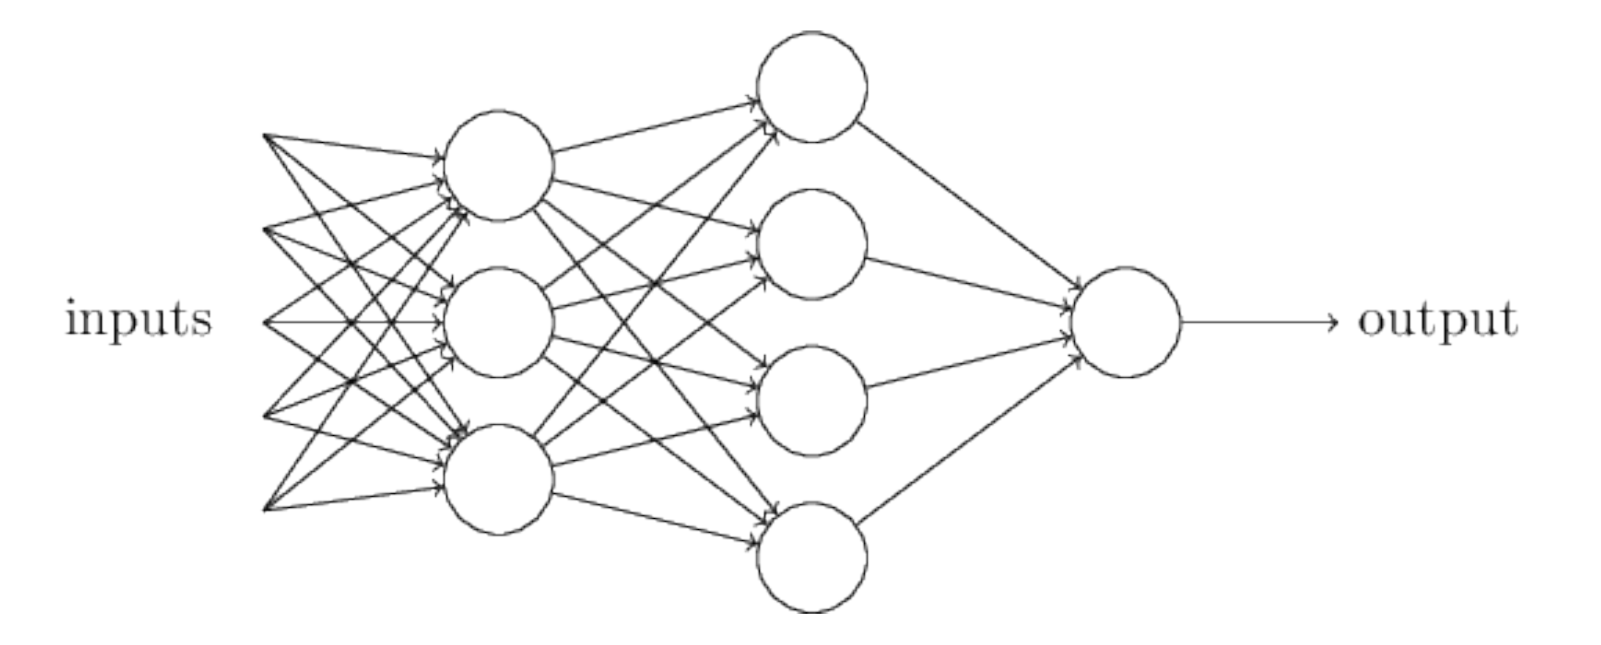

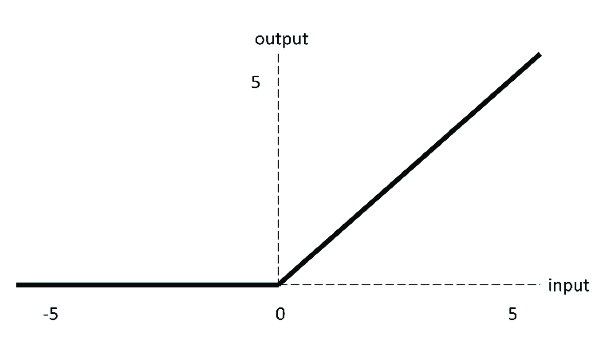

In [2]:
class FullyConnectedNetwork(nn.Module):  # https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    def __init__(
        self, 
        img_size: Tuple[int, int] = (1, 28, 28),  # (кол-во каналов, высота px, ширина px)
        num_classes: int = 10,
    ):
        super().__init__()
        # Линейный слой в качестве входа принимает вектор:
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        #
        # Является умножением матрицы-весов на входной вектор признаков:
        # Почему x * A^T + b, а не A^T * x + b?
        input_features = img_size[0] * img_size[1] * img_size[2]
        
        self.fc1 = nn.Linear(input_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x: torch.Tensor):
        # x - имеет размерность [batch_size, *], в нашем случае [batch_size, input_features].
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        
        return x

In [3]:
model = FullyConnectedNetwork()

In [4]:
[(name, parameter.shape) for name, parameter in model.named_parameters()]

[('fc1.weight', torch.Size([128, 784])),
 ('fc1.bias', torch.Size([128])),
 ('fc2.weight', torch.Size([64, 128])),
 ('fc2.bias', torch.Size([64])),
 ('fc3.weight', torch.Size([10, 64])),
 ('fc3.bias', torch.Size([10]))]

## Сохранение/загрузка параметров модели

Параметры, определяющие модель, можно сохранить и загрузить.

Это удобно для сохранения промежуточных результатов и последующего деплоя модели.

In [5]:
model.state_dict()  # Ключ - имя параметра, значение - тензор

OrderedDict([('fc1.weight',
              tensor([[ 0.0181, -0.0263, -0.0188,  ...,  0.0314,  0.0047,  0.0199],
                      [-0.0318,  0.0171,  0.0148,  ...,  0.0292, -0.0352, -0.0146],
                      [ 0.0062, -0.0316, -0.0061,  ...,  0.0266, -0.0169,  0.0156],
                      ...,
                      [ 0.0238,  0.0139,  0.0135,  ...,  0.0347, -0.0279,  0.0034],
                      [ 0.0177,  0.0136, -0.0186,  ...,  0.0129,  0.0216,  0.0094],
                      [ 0.0132, -0.0010, -0.0007,  ...,  0.0175,  0.0337,  0.0334]])),
             ('fc1.bias',
              tensor([ 0.0143,  0.0188, -0.0336, -0.0169,  0.0105,  0.0231,  0.0096, -0.0138,
                      -0.0273, -0.0216, -0.0038,  0.0128,  0.0057,  0.0005, -0.0165, -0.0100,
                      -0.0183,  0.0124, -0.0172,  0.0177,  0.0285, -0.0156,  0.0321,  0.0280,
                       0.0260,  0.0175,  0.0012,  0.0356, -0.0208, -0.0263,  0.0256,  0.0257,
                       0.0110,  0.02

In [6]:
torch.save(  # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    obj=model.state_dict(),
    f='weights.pt',
)

In [7]:
loaded_state_dict = torch.load('weights.pt')
loaded_state_dict

OrderedDict([('fc1.weight',
              tensor([[ 0.0181, -0.0263, -0.0188,  ...,  0.0314,  0.0047,  0.0199],
                      [-0.0318,  0.0171,  0.0148,  ...,  0.0292, -0.0352, -0.0146],
                      [ 0.0062, -0.0316, -0.0061,  ...,  0.0266, -0.0169,  0.0156],
                      ...,
                      [ 0.0238,  0.0139,  0.0135,  ...,  0.0347, -0.0279,  0.0034],
                      [ 0.0177,  0.0136, -0.0186,  ...,  0.0129,  0.0216,  0.0094],
                      [ 0.0132, -0.0010, -0.0007,  ...,  0.0175,  0.0337,  0.0334]])),
             ('fc1.bias',
              tensor([ 0.0143,  0.0188, -0.0336, -0.0169,  0.0105,  0.0231,  0.0096, -0.0138,
                      -0.0273, -0.0216, -0.0038,  0.0128,  0.0057,  0.0005, -0.0165, -0.0100,
                      -0.0183,  0.0124, -0.0172,  0.0177,  0.0285, -0.0156,  0.0321,  0.0280,
                       0.0260,  0.0175,  0.0012,  0.0356, -0.0208, -0.0263,  0.0256,  0.0257,
                       0.0110,  0.02

In [8]:
model.load_state_dict(loaded_state_dict)  # Загрузили в модель веса

<All keys matched successfully>

## Подготовка данных

In [9]:
# Обработка входного изображения:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.5],
        std=[0.5],
    ),
])

In [10]:
# В PyTorch есть 2 основных класса для работы с тренировочными данными:
#
# 1. Dataset: https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
# Загружает и обрабатывает данные.
train_dataset = torchvision.datasets.MNIST(  # MNIST - база изображений рукописных цифр.
    root='datasets',
    download=True,
    train=True,
    transform=transform,
)

# 2. Dataloader: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
# Производит пакетный (batch) поток данных.
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
)

In [11]:
valid_dataset = torchvision.datasets.MNIST(
    root='datasets',
    download=True,
    train=False,
    transform=transform,
)

valid_dataloader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
)

In [12]:
batch, _ = next(iter(train_dataloader))

In [13]:
batch.shape

torch.Size([256, 1, 28, 28])

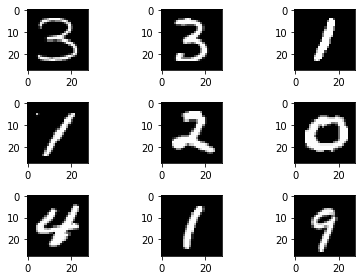

In [14]:
figure = plt.figure()

for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.tight_layout()
    plt.imshow(batch[index][0], cmap='gray', interpolation='none')

## Обучение

In [15]:
criterion = nn.NLLLoss()  # https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html

optimizer = torch.optim.SGD(  # https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
    params=model.parameters(),  # Параметры, которые будут обучаться в процессе тренировки сети
    lr=0.01,
    momentum=0.9,
)


def train_step() -> float:
    model.train()
    
    running_loss = 0.
    for images, labels in train_dataloader:
        images = images.view(images.shape[0], -1)  # [256, 1, 28, 28] -> [256, 1 * 28 * 28]
        
        # Удаляем накопленные ранее градиенты.
        # parameter.grad = 0
        optimizer.zero_grad()
        
        # Делаем проход (forward pass).
        # Состояние модели `train` обеспечивает сохранение промежуточных результатов вычислений.
        # Эти сохраненные значения будут использованы ниже для вычисления градиента функции потерь.
        output = model(images)
        
        # Вычисляем функцию потерь на основе предсказания модели.
        loss = criterion(output, labels)

        # Вычисляем градиент: направление, в котором функция потерь возрастает максимально быстро.
        # parameter.grad += dloss / dparameter
        loss.backward()

        # parameter += -lr * parameter.grad
        # 
        # PyTorch SGD:
        # velocity = momentum * velocity + parameter.grad
        # parameter += - lr * velocity
        optimizer.step()
        
        # Накапливаем статистику.
        running_loss += loss
    
    # Контекстный менеджер `torch.no_grad` позволяет отключить вычисление градиентов.
    # Вычисления, в которые входят обучаемые параметры, не имеющие отношения к сети повлияют на процесс обучения,
    # если для них будут накапливаться градиенты.
    # Экономия памяти.
    with torch.no_grad():
        train_loss = running_loss / len(train_dataloader)
    return train_loss.item()


def valid_step() -> Tuple[float, float]:
    model.eval()

    correct_total = 0.
    running_loss = 0.
    with torch.no_grad():
        for images, labels in valid_dataloader:
            images = images.view(images.shape[0], -1)

            output = model(images)
            
            prediction = output.max(  # [bs, num_classes] -> [bs, 1]
                dim=1,
                keepdim=True,
            )[1]
            correct_total += prediction.eq(labels.view_as(prediction)).sum()
            
            loss = criterion(output, labels)
            running_loss += loss
        
    valid_loss = running_loss / len(valid_dataloader)
    accuracy = correct_total / len(valid_dataloader.dataset)
    return valid_loss.item(), accuracy.item()

In [16]:
train_losses = []
valid_losses = []
valid_accs = []

In [17]:
epochs = 50
model  # model.to('cuda:0')

for _ in (pbar := tqdm(range(epochs))):
    train_loss = train_step()
    valid_loss, valid_acc = valid_step()
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    pbar.set_description(f'Avg. train/valid loss: {train_loss:.4f}/{valid_loss:.4f}')

Avg. train/valid loss: 0.0051/0.0825: 100%|████████████████████████████████████████████████████████████| 50/50 [01:27<00:00,  1.75s/it]


Text(0, 0.5, 'Loss')

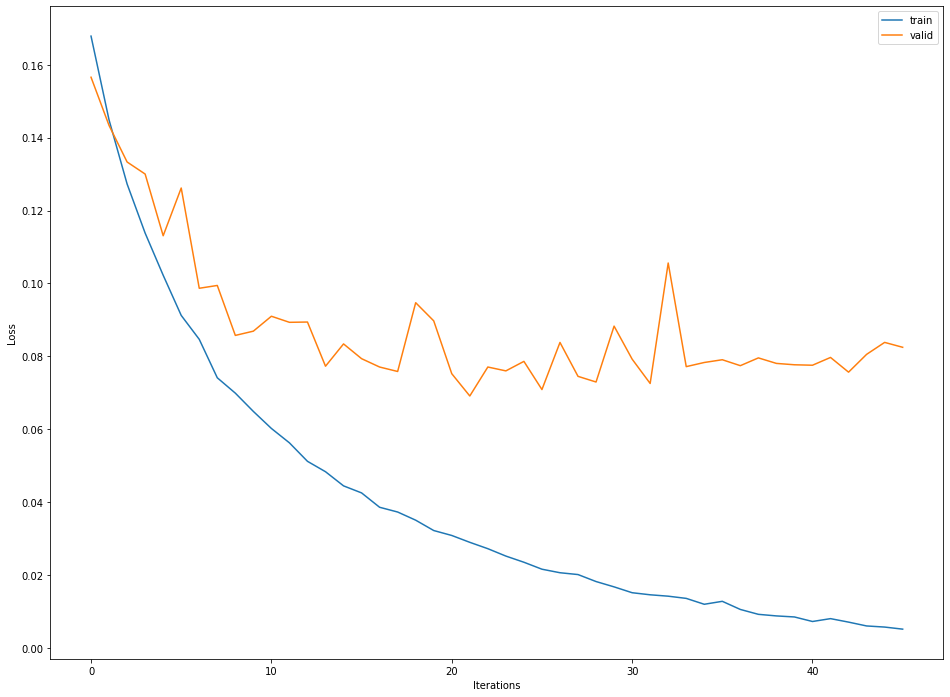

In [18]:
fig = plt.figure(figsize=(16, 12))

plt.plot(train_losses[4:], label='train')
plt.plot(valid_losses[4:], label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

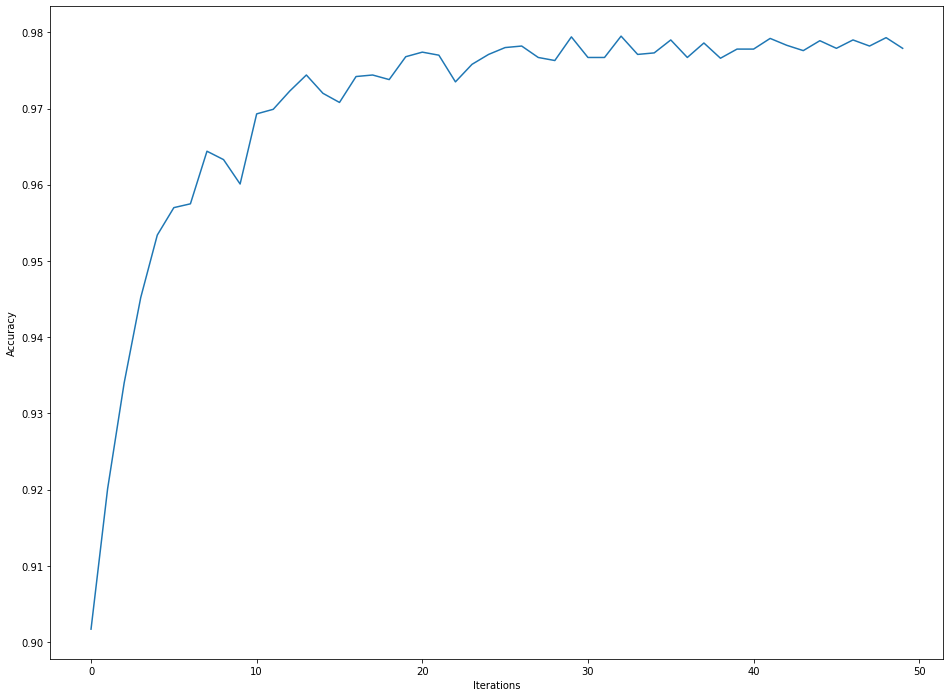

In [19]:
fig = plt.figure(figsize=(16, 12))

plt.plot(valid_accs)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

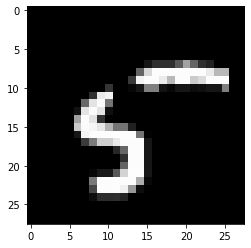

In [20]:
batch, _ = next(iter(train_dataloader))
sample = batch[randrange(0, 255)]
plt.imshow(sample[0], cmap='gray', interpolation='none')

In [21]:
prediction = model(sample.view(sample.shape[0], -1))

In [22]:
prediction

tensor([[-2.2252e+01, -2.7214e+01, -2.8511e+01, -2.7309e+01, -3.1427e+01,
         -1.2159e-05, -2.8133e+01, -2.5679e+01, -1.1322e+01, -2.7454e+01]],
       grad_fn=<LogSoftmaxBackward0>)

In [23]:
prediction.max(
    dim=1,
    keepdim=True,
)[1].item()

5

***

## Что еще можно посмотреть?

https://web.stanford.edu/class/cs224n/materials/CS224N_PyTorch_Tutorial.html